### Extract SUNTANS SSH data to be SWOT-like

In [2]:
import sfoda.suntans.sunxarray as sxr

import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from cmocean import cm
from s3fs import S3FileSystem, S3Map

In [3]:
s3login = '/home/jupyter-mrayson/s3.acacia.login'

with open(s3login) as f:
    lines = f.readlines()

url, key, secret = [ff.strip('\n') for ff in lines[0:3]]
s3 = S3FileSystem(client_kwargs={'endpoint_url':url},
            key=key,
            secret=secret)

In [4]:
f = S3Map("uwaoceanprocesses-suntans/NWS_2km_GLORYS_2013_2014_surface.zarr/", s3=s3)
varname = 'eta'
t1,t2 = '2014-03-01','2014-07-01'

ds = xr.open_dataset(f, engine='zarr', chunks={}).sel(time=slice(t1,t2))
# These need filling in??
ds.suntans.xv=ds.xv.values
ds.suntans.yv=ds.yv.values

ds

Changing the _FillValue from -999999 to 999999


<xarray.Dataset>
Dimensions:  (Nc: 225368, numsides: 8, Nk: 80, time: 2933, Np: 454016)
Coordinates:
  * time     (time) datetime64[ns] 2014-03-01 2014-03-01T00:01:00 ... 2014-07-01
    z_r      (Nk) float64 dask.array<chunksize=(80,), meta=np.ndarray>
Dimensions without coordinates: Nc, numsides, Nk, Np
Data variables:
    cells    (Nc, numsides) int32 dask.array<chunksize=(2000, 8), meta=np.ndarray>
    dv       (Nc) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
    dz       (Nk) float64 dask.array<chunksize=(80,), meta=np.ndarray>
    eta      (time, Nc) float64 dask.array<chunksize=(121, 2000), meta=np.ndarray>
    nfaces   (Nc) int32 dask.array<chunksize=(2000,), meta=np.ndarray>
    temp     (time, Nc) float64 dask.array<chunksize=(121, 2000), meta=np.ndarray>
    uc       (time, Nc) float64 dask.array<chunksize=(121, 2000), meta=np.ndarray>
    vc       (time, Nc) float64 dask.array<chunksize=(121, 2000), meta=np.ndarray>
    xp       (Np) float64 dask.array<chunksize=(454016,), meta=np.ndarray>
    xv       (Nc) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
    yp       (Np) float64 dask.array<chunksize=(454016,), meta=np.ndarray>
    yv       (Nc) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
Attributes:
    Author:       mrayson
    Description:  SUNTANS surface fields

In [6]:
# Open the swot data to get the target lon/lat
pass_no = 21
region = 'browsebasin'
swot_file = f'/home/jupyter-mrayson/data/SWOT/l2_l3_combined/SWOT_L2L3_LR_SSH_CALVAL_0{pass_no}_{region}.nc'

ds_swot = xr.open_dataset(swot_file).isel(num_lines=slice(50,-1))
ds_swot

<xarray.Dataset>
Dimensions:             (num_lines: 239, num_pixels: 69, cycle: 98)
Coordinates:
    latitude            (num_lines, num_pixels) float64 ...
    longitude           (num_lines, num_pixels) float64 ...
    latitude_nadir      (cycle, num_lines) float64 ...
    longitude_nadir     (cycle, num_lines) float64 ...
  * cycle               (cycle) int64 476 478 479 480 481 ... 574 575 576 577
Dimensions without coordinates: num_lines, num_pixels
Data variables:
    ssha_l3             (cycle, num_lines, num_pixels) float64 ...
    ssha_l2             (cycle, num_lines, num_pixels) float64 ...
    ssha_l2_l3_all      (cycle, num_lines, num_pixels) float64 ...
    ssha_l2_l3_dynamic  (cycle, num_lines, num_pixels) float64 ...
    time                (cycle, num_lines, num_pixels) datetime64[ns] ...
Attributes:
    l2_version:    V1.2.1
    l3_version:    1.0
    l2_file:       /home/jupyter-mrayson/data/SWOT/l2_karin_v1_0/cycle_476/SW...
    l3_file:       /home/jupyter-mrayson/data/SWOT/l3_karin_nadir_v1_0/cycle_...
    quality_flag:  good

In [7]:
%%time
from sfoda.utils.barycentric import BarycentricInterp
# Build the interpolation objection
xyin = np.vstack([ds.xv,ds.yv]).T
x_swot, y_swot = ds_swot['longitude'].values, ds_swot['latitude'].values
xyout = np.vstack([x_swot.ravel(), y_swot.ravel()]).T
F = BarycentricInterp(xyin, xyout)

CPU times: user 3.92 s, sys: 1.26 s, total: 5.18 s
Wall time: 5.52 s


In [16]:
%%time
M,N = ds_swot['longitude'].shape
NT = ds.time.shape[0]

eta = ds['eta'].values

CPU times: user 13.7 s, sys: 4.63 s, total: 18.3 s
Wall time: 44.1 s


In [17]:
from tqdm import tqdm

In [18]:

eta_swot = np.zeros((NT,M,N))

for ii in tqdm(range(NT)):
    eta_swot[ii,...] = F(eta[ii,:]).reshape(M,N)

100%|██████████| 2933/2933 [00:04<00:00, 677.39it/s] 


In [19]:
del eta

In [20]:
def fit2Dsurf(x,y,p,kind='linear'):
    """
    Computes the best-fit 2D surface of the form
    p = a + bx + cy + dx^2 + ey^2 + fxy (quadratic) or
    p = a + bx + cy (linear) depending on the value of kind. 
    The best-fit surface is determined by minimizing the sum 
    of squared residuals between the functional surface and the input data.

    Parameters
    ----------
    x : numpy.ndarray
        A 2D array or a list of x-coordinates.
    y : numpy.ndarray
        A 2D array or a list of y-coordinates.
    p : numpy.ndarray
        A 2D array or a list of data values on (x,y) grid.
    kind : str, optional
        The type of surface to fit to the data. Can be either 'linear'
        or 'quadratic'. Default is 'linear'.

    Returns
    -------
    numpy.ndarray, numpy.ndarray
        The computed anomaly and mean surfaces. The anomaly surface is 
        given by the difference between the input data and the mean surface.
        The mean surface is computed by evaluating the best-fit 2D surface
        at the input coordinates.
    """
    
    from scipy.optimize import leastsq
    import numpy as np

    def err(c,x0,y0,p):
        if kind=='linear':
            a,b,c=c
            return p - (a + b*x0 + c*y0 )
        if kind=='quadratic':
            a,b,c,d,e,f=c
            return p - (a + b*x0 + c*y0 + d*x0**2 + e*y0**2 + f*x0*y0)

    def surface(c,x0,y0):
        if kind=='linear':
            a,b,c=c
            return a + b*x0 + c*y0 
        if kind=='quadratic':
            a,b,c,d,e,f=c
            return a + b*x0 + c*y0 + d*x0**2 + e*y0**2 + f*x0*y0

    
    aa=x*y*p
    msk=np.isfinite(aa.flatten())
    #x=x.flatten()[msk];y=y.flatten()[msk];p=p.flatten()[msk]
    
    #dpdy = (np.diff(p,axis=0)/np.diff(y,axis=0)).mean()
    #dpdx = (np.diff(p,axis=1)/np.diff(x,axis=1)).mean()
    dpdx=(p.max()-p.min())/(x.max()-x.min())
    dpdy=(p.max()-p.min())/(y.max()-y.min())
    xf=x.flatten()[msk]
    yf=y.flatten()[msk]
    pf=p.flatten()[msk]

    
    if kind=='linear':
        c = [pf.mean(),dpdx,dpdy]
    if kind=='quadratic':
        c = [pf.mean(),dpdx,dpdy,1e-22,1e-22,1e-22]

    coef = leastsq(err,c,args=(xf,yf,pf))[0]
    vm = surface(coef,x,y) #mean surface
    va = p - vm #anomaly
    
    return va,vm

In [22]:
%%time
eta_tide = np.zeros((NT,M,N))
eta_a  = np.zeros((NT,M,N))

for ii in tqdm(range(NT)):
    eta_a[ii,...], eta_tide[ii,...] = fit2Dsurf(x_swot, y_swot, eta_swot[ii,...], kind='quadratic')

100%|██████████| 2933/2933 [00:11<00:00, 244.82it/s]

CPU times: user 12 s, sys: 15.5 ms, total: 12 s
Wall time: 12 s


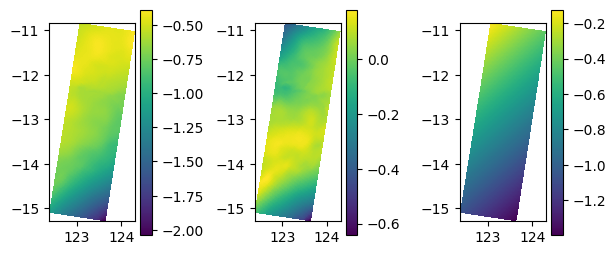

In [14]:
plt.figure()
ax=plt.subplot(131)
plt.pcolormesh(x_swot, y_swot, eta_swot[ii,...])
plt.colorbar(shrink=0.5)
plt.gca().set_aspect('equal')

ax=plt.subplot(132)
plt.pcolormesh(x_swot, y_swot, eta_a[ii,...])
plt.colorbar(shrink=0.5)
plt.gca().set_aspect('equal')


ax=plt.subplot(133)
plt.pcolormesh(x_swot, y_swot, eta_tide[ii,...])
plt.colorbar(shrink=0.5)
plt.gca().set_aspect('equal')
plt.tight_layout()

In [26]:
ds_swot['ssha_l2'].coords

Coordinates:
    latitude         (num_lines, num_pixels) float64 -15.09 -15.1 ... -11.03
    longitude        (num_lines, num_pixels) float64 122.4 122.4 ... 124.3 124.3
    latitude_nadir   (cycle, num_lines) float64 ...
    longitude_nadir  (cycle, num_lines) float64 ...
  * cycle            (cycle) int64 476 478 479 480 481 ... 573 574 575 576 577

In [53]:
# create swot-like output arrays
ssh = xr.DataArray(eta_swot, 
        dims=ds_swot['ssha_l2'].dims,
        coords=dict(cycle=range(NT), longitude=ds_swot['longitude'], latitude=ds_swot['latitude'])
                )

ssha = xr.DataArray(eta_a, 
        dims=ds_swot['ssha_l2'].dims,
        coords=dict(cycle=range(NT), longitude=ds_swot['longitude'], latitude=ds_swot['latitude'])
                )

ocean_tide = xr.DataArray(eta_tide, 
        dims=ds_swot['ssha_l2'].dims,
        coords=dict(cycle=range(NT), longitude=ds_swot['longitude'], latitude=ds_swot['latitude'])
                )
swot_time = ds.time.expand_dims(dim={'num_lines':ds_out['num_lines'],
                        'num_pixels':ds_out['num_pixels']})
swot_time = swot_time.assign_coords({'time':range(NT)})\
    .rename({'time':'cycle'})\
    .transpose('cycle','num_lines','num_pixels')

ds_out = xr.Dataset({'ssh':ssh, 'ssha':ssha, 'ocean_tide':ocean_tide, 'time':swot_time})
ds_out

<xarray.Dataset>
Dimensions:     (cycle: 2933, num_lines: 239, num_pixels: 69)
Coordinates:
  * cycle       (cycle) int64 0 1 2 3 4 5 6 ... 2927 2928 2929 2930 2931 2932
    longitude   (num_lines, num_pixels) float64 122.4 122.4 ... 124.3 124.3
    latitude    (num_lines, num_pixels) float64 -15.09 -15.1 ... -11.03 -11.03
  * num_lines   (num_lines) int64 0 1 2 3 4 5 6 ... 232 233 234 235 236 237 238
  * num_pixels  (num_pixels) int64 0 1 2 3 4 5 6 7 8 ... 61 62 63 64 65 66 67 68
Data variables:
    ssh         (cycle, num_lines, num_pixels) float64 0.08435 ... -0.3949
    ssha        (cycle, num_lines, num_pixels) float64 -0.1813 ... 0.04916
    ocean_tide  (cycle, num_lines, num_pixels) float64 0.2657 0.2637 ... -0.4441
    time        (cycle, num_lines, num_pixels) datetime64[ns] 2014-03-01 ... ...

In [54]:
outfile = '/home/jupyter-mrayson/data/SWOT/Karin_SUNTANS_OSSE_1HR.nc'
ds_out.to_netcdf(outfile)

/tmp/ipykernel_2653338/1330311455.py:2: SerializationWarning: saving variable longitude with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_out.to_netcdf(outfile)
/tmp/ipykernel_2653338/1330311455.py:2: SerializationWarning: saving variable latitude with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_out.to_netcdf(outfile)


In [81]:
# Interpolate in time onto SWOT-like spacing
t = ds_swot.time[:,12,20].values
dt_swot = t[1::] - t[0:-1]
dt = dt_swot[1:5].mean()

t0 = ds.time[0].values

tout = np.array([t0 +dt + dt*ii for ii in range(93)])


/home/jupyter-mrayson/.local/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


In [82]:
dt.astype(float)/1e9/3600

23.843838311831114

In [84]:
from scipy.interpolate import interp1d

F = interp1d(ds.time.values.astype('float'), ds_out['cycle'] )

cycle_out = F(tout.astype(float))



array([  24.84383831,   48.68767662,   72.53151494,   96.37535325,
        120.21919156,  144.06302987,  167.90686818,  191.75070649,
        215.59454481,  239.43838312,  263.28222143,  287.12605974,
        310.96989805,  334.81373637,  358.65757468,  382.50141299,
        406.3452513 ,  430.18908961,  454.03292792,  477.87676624,
        501.72060455,  525.56444286,  549.40828117,  573.25211948,
        597.0959578 ,  620.93979611,  644.78363442,  668.62747273,
        692.47131104,  716.31514935,  740.15898767,  765.00282598,
        788.84666429,  812.6905026 ,  836.53434091,  860.37817923,
        884.22201754,  908.06585585,  931.90969416,  955.75353247,
        979.59737079, 1003.4412091 , 1027.28504741, 1051.12888572,
       1074.97272403, 1098.81656234, 1122.66040066, 1146.50423897,
       1170.34807728, 1194.19191559, 1218.0357539 , 1241.87959222,
       1265.72343053, 1289.56726884, 1313.41110715, 1337.25494546,
       1361.09878377, 1384.94262209, 1408.7864604 , 1432.63029

In [86]:
ds_out_swot = ds_out.interp(cycle=cycle_out)
ds_out_swot

<xarray.Dataset>
Dimensions:     (num_lines: 239, num_pixels: 69, cycle: 93)
Coordinates:
    longitude   (num_lines, num_pixels) float64 122.4 122.4 ... 124.3 124.3
    latitude    (num_lines, num_pixels) float64 -15.09 -15.1 ... -11.03 -11.03
  * num_lines   (num_lines) int64 0 1 2 3 4 5 6 ... 232 233 234 235 236 237 238
  * num_pixels  (num_pixels) int64 0 1 2 3 4 5 6 7 8 ... 61 62 63 64 65 66 67 68
  * cycle       (cycle) float64 24.84 48.69 72.53 ... 2.197e+03 2.221e+03
Data variables:
    ssh         (cycle, num_lines, num_pixels) float64 -0.6925 ... -0.8253
    ssha        (cycle, num_lines, num_pixels) float64 -0.181 -0.1861 ... 0.1494
    ocean_tide  (cycle, num_lines, num_pixels) float64 -0.5116 ... -0.9747

In [102]:

# tout_swot = np.broadcast_to(tout, ( 239,69, tout.shape[0]))
# print(tout_swot.shape)
# tout_swot = np.moveaxis(tout_swot, 0, -1)
# tout_swot.shape
tout_da = xr.DataArray(tout, coords={'cycle':cycle_out})
tout_da
tout_da = tout_da.expand_dims(dim={'num_lines':ds_out['num_lines'],
                        'num_pixels':ds_out['num_pixels']})
ds_out_swot.update({'time': tout_da.transpose('cycle','num_lines','num_pixels')})
ds_out_swot
# new_swot_time = stout_da.assign_coords({'time':range(NT)})\
#     .rename({'time':'cycle'})\
#     .transpose('cycle','num_lines','num_pixels')

<xarray.Dataset>
Dimensions:     (num_lines: 239, num_pixels: 69, cycle: 93)
Coordinates:
    longitude   (num_lines, num_pixels) float64 122.4 122.4 ... 124.3 124.3
    latitude    (num_lines, num_pixels) float64 -15.09 -15.1 ... -11.03 -11.03
  * num_lines   (num_lines) int64 0 1 2 3 4 5 6 ... 232 233 234 235 236 237 238
  * num_pixels  (num_pixels) int64 0 1 2 3 4 5 6 7 8 ... 61 62 63 64 65 66 67 68
  * cycle       (cycle) float64 24.84 48.69 72.53 ... 2.197e+03 2.221e+03
Data variables:
    ssh         (cycle, num_lines, num_pixels) float64 -0.6925 ... -0.8253
    ssha        (cycle, num_lines, num_pixels) float64 -0.181 -0.1861 ... 0.1494
    ocean_tide  (cycle, num_lines, num_pixels) float64 -0.5116 ... -0.9747
    time        (cycle, num_lines, num_pixels) datetime64[ns] 2014-03-01T23:5...

In [103]:
outfile = '/home/jupyter-mrayson/data/SWOT/Karin_SUNTANS_OSSE_Daily.nc'
ds_out_swot.to_netcdf(outfile)

/tmp/ipykernel_2653338/3656454480.py:2: SerializationWarning: saving variable longitude with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_out_swot.to_netcdf(outfile)
/tmp/ipykernel_2653338/3656454480.py:2: SerializationWarning: saving variable latitude with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_out_swot.to_netcdf(outfile)
